# Tarea: Clasificación técnica mediante SVM y Árboles de Decisión

**Equipo 2:** 

JAVIER ALEJANDRO VEGA MOLINA

SANTIAGO GERARDO SALAZAR RUIZ

FABRICIO ARTURO BERMUDEZ ZAMBRANO

FREDY RICARDO CRUZ SANTANA

---

### Parte 1: Comprensión del Problema

**1. ¿Qué problema estamos resolviendo?**
Estamos resolviendo la **detección proactiva de fallos** en un sistema de archivos distribuido (Hadoop HDFS). El objetivo es construir un modelo que analice las secuencias de logs del sistema y prediga si un componente (un "bloque" de datos) va a fallar, *antes* de que ocurra el fallo.

**2. ¿Qué tipo de datos se necesitan?**
Se necesitan dos tipos de datos:
* **Logs crudos del sistema (`HDFS.log`):** Registros de eventos con marca de tiempo, generados por el servidor.
* **Etiquetas de anomalías (`anomaly_label.csv`):** Un archivo que nos dice qué secuencias de logs (agrupadas por `Block_ID`) corresponden a un funcionamiento "Normal" y cuáles a una "Anomalía" (fallo).

**3. ¿Cómo evaluaremos el éxito del modelo?**
Los fallos son eventos raros, por lo que el dataset estará **altamente desbalanceado**. Por lo tanto, la "Accuracy" (exactitud) no es una buena métrica. Usaremos:
* **Precision (Precisión):** Mide la calidad de nuestras alertas. De todas las que generamos, ¿cuántas fueron fallos reales?
* **Recall (Sensibilidad):** Mide nuestra capacidad de detectar fallos. De todos los fallos que ocurrieron, ¿cuántos detectamos?
* **F1-Score:** La media armónica de Precision y Recall. Es nuestra métrica principal.
* **Matriz de Confusión:** Para ver visualmente los Falsos Positivos y Falsos Negativos.


In [ ]:
# Instalacion de dependencias
%pip install numpy pandas scikit-learn seaborn matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: c:\Users\javie\.pyenv\pyenv-win\versions\3.13.5\python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Configuración para que los gráficos se vean bien
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

### Parte 2: Recolección y Análisis Exploratorio (EDA)

Primero, vamos a inspeccionar los datos crudos para entender cómo se ven.

In [6]:
# Cargar solo las primeras 10 filas del log crudo para ver su estructura
# NOTA: Usamos 'header=None' y 'sep' un delimitador improbable para leer la línea completa
print("--- Mostrando 10 líneas del log crudo (HDFS.log) ---")
try:
    with open("dataset/HDFS.log", "r") as f:
        for i in range(10):
            print(f.readline().strip())
except FileNotFoundError:
    print("Error: No se encontró el archivo 'dataset/HDFS.log'.")
    print("Asegúrate de que la ruta sea correcta.")

--- Mostrando 10 líneas del log crudo (HDFS.log) ---
081109 203518 143 INFO dfs.DataNode$DataXceiver: Receiving block blk_-1608999687919862906 src: /10.250.19.102:54106 dest: /10.250.19.102:50010
081109 203518 35 INFO dfs.FSNamesystem: BLOCK* NameSystem.allocateBlock: /mnt/hadoop/mapred/system/job_200811092030_0001/job.jar. blk_-1608999687919862906
081109 203519 143 INFO dfs.DataNode$DataXceiver: Receiving block blk_-1608999687919862906 src: /10.250.10.6:40524 dest: /10.250.10.6:50010
081109 203519 145 INFO dfs.DataNode$DataXceiver: Receiving block blk_-1608999687919862906 src: /10.250.14.224:42420 dest: /10.250.14.224:50010
081109 203519 145 INFO dfs.DataNode$PacketResponder: PacketResponder 1 for block blk_-1608999687919862906 terminating
081109 203519 145 INFO dfs.DataNode$PacketResponder: PacketResponder 2 for block blk_-1608999687919862906 terminating
081109 203519 145 INFO dfs.DataNode$PacketResponder: Received block blk_-1608999687919862906 of size 91178 from /10.250.10.6
081109

Como podemos ver, los logs son texto no estructurado. Cada línea contiene una marca de tiempo, un ID de proceso, el tipo de evento (INFO, WARN, etc.) y un mensaje.

Ahora, la parte más importante del EDA: **analizar las etiquetas** para entender la distribución del problema.

                    BlockId    Label
0  blk_-1608999687919862906   Normal
1   blk_7503483334202473044   Normal
2  blk_-3544583377289625738  Anomaly
3  blk_-9073992586687739851   Normal
4   blk_7854771516489510256   Normal

--- Distribución de Clases (Normal vs. Anomalía) ---
Label
Normal     558223
Anomaly     16838
Name: count, dtype: int64

Porcentaje Normal: 97.07%
Porcentaje Anomalía: 2.93%


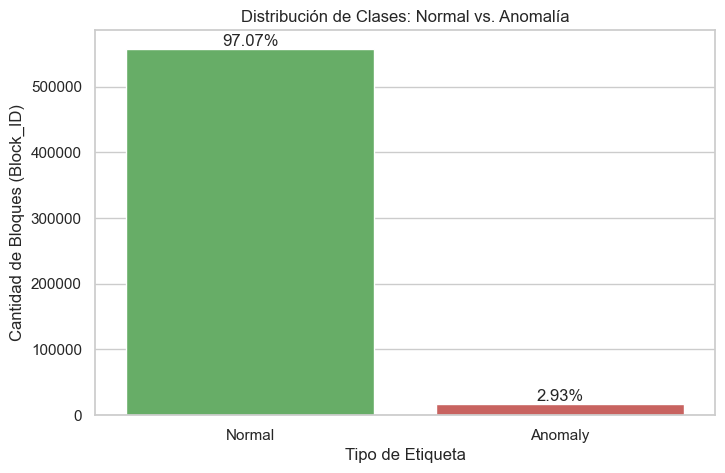

In [12]:
# Cargar las etiquetas de anomalías
try:
    labels_df = pd.read_csv("dataset/preprocessed/anomaly_label.csv")

    print(labels_df.head())
    print("\n--- Distribución de Clases (Normal vs. Anomalía) ---")

    # Contar los valores
    label_counts = labels_df['Label'].value_counts()
    print(label_counts)

    # Calcular porcentaje (lo usaremos para los prints y las anotaciones)
    total = len(labels_df)
    
    # --- MODIFICACIÓN INICIA ---

    # Graficar la distribución
    plt.figure(figsize=(8, 5))
    
    # 1. Captura el eje (axes) en una variable 'ax'
    ax = sns.countplot(x='Label', data=labels_df, hue="Label", legend=False, palette=['#5cb85c', '#d9534f'])
    
    plt.title('Distribución de Clases: Normal vs. Anomalía')
    plt.ylabel('Cantidad de Bloques (Block_ID)')
    plt.xlabel('Tipo de Etiqueta')

    # 2. Agrega un bucle para anotar cada barra
    for p in ax.patches:
        height = p.get_height()           # Obtiene la altura (conteo) de la barra
        percentage = 100 * height / total # Calcula el porcentaje
        
        # Prepara el texto de la etiqueta
        label_text = f'{percentage:.2f}%' 

        # Añade el texto al gráfico
        ax.text(
            p.get_x() + p.get_width() / 2,  # Posición X (en el centro de la barra)
            height,                         # Posición Y (justo en la parte superior de la barra)
            label_text,                     # El texto a mostrar
            ha='center',                    # Alineación horizontal
            va='bottom'                     # Alineación vertical (para que empiece *sobre* la barra)
        )
    
    # --- MODIFICACIÓN TERMINA ---

    # Imprimir los porcentajes en la consola (como ya lo tenías)
    normal_pct = (label_counts['Normal'] / total) * 100
    anomaly_pct = (label_counts['Anomaly'] / total) * 100

    print(f"\nPorcentaje Normal: {normal_pct:.2f}%")
    print(f"Porcentaje Anomalía: {anomaly_pct:.2f}%")

    plt.show()

except FileNotFoundError:
    print("Error: No se encontró el archivo 'dataset/preprocessed/anomaly_label.csv'.")
    print("Asegúrate de que la ruta sea correcta.")

**Insight Clave del EDA:** El gráfico confirma que el dataset es **extremadamente desbalanceado**. Menos del 3% de las muestras son anomalías. Esto justifica por qué debemos usar `Recall` y `F1-Score` como métricas principales y no `Accuracy`.

### Parte 2 (Continuación): Preprocesamiento e Ingeniería de Características

El paso para convertir `HDFS.log` en datos numéricos que un modelo pueda entender es:

1.  **Parsing (Análisis):** Se usa un algoritmo para leer todos los logs crudos y extraer "plantillas" de eventos. (Ej. `Receiving block * from *` es una plantilla). El archivo `HDFS.log_templates.csv` contiene estas plantillas.
2.  **Agrupación:** Se agrupan las secuencias de logs por el `Block_ID` al que pertenecen.
3.  **Vectorización (Ingeniería de Características):** Para cada `Block_ID`, se cuenta cuántas veces apareció cada "plantilla" de evento en su secuencia.

Este proceso es muy complejo. Afortunadamente, el dataset nos provee el resultado de este paso en el archivo `Event_occurrence_matrix.csv`. Vamos a cargar esta matriz para usarla como nuestras características (`X`).

In [19]:
# Cargar la matriz de características (X)
try:
    features_df = pd.read_csv("dataset/preprocessed/Event_occurrence_matrix.csv")

    # Cargar las etiquetas (y)
    labels_df = pd.read_csv("dataset/preprocessed/anomaly_label.csv")

    # Limpiar nombres de columnas por si acaso (elimina espacios)
    features_df.columns = features_df.columns.str.strip()
    labels_df.columns = labels_df.columns.str.strip()
    
    # Unir las características con las etiquetas usando el Block_ID
    # Asumiendo que la columna se llama 'BlockId' en ambos, según tu código
    data_df = pd.merge(features_df, labels_df, on='BlockId')

    print("--- Datos combinados (Características + Etiquetas) ---")
    print(data_df.head())

    # Inspeccionar los datos
    print("\n--- Información del DataFrame ---")
    data_df.info()

except FileNotFoundError:
    print("Error: No se encontraron los archivos en 'dataset/preprocessed/'.")
    print("Asegúrate de que la ruta sea correcta.")
except KeyError as e:
    print(f"Error de Llave (KeyError): No se encontró la columna {e} para hacer el merge.")
    print("Verifica los nombres de las columnas en tus archivos CSV.")

--- Datos combinados (Características + Etiquetas) ---
                    BlockId  Label_x  Type  E1  E2   E3  E4  E5  E6  E7  ...  \
0  blk_-1608999687919862906  Success   NaN   0   0  203   0  10   7   0  ...   
1   blk_7503483334202473044  Success   NaN   0   2    1   0   3   0   0  ...   
2  blk_-3544583377289625738     Fail  21.0   0   0  203   0   3   0   0  ...   
3  blk_-9073992586687739851  Success   NaN   0   3    0   0   3   0   0  ...   
4   blk_7854771516489510256  Success   NaN   0   3    1  15   3   0   0  ...   

   E21  E22  E23  E24  E25  E26  E27  E28  E29  Label_y  
0   10    1   10    0    4   10    0    0    0   Normal  
1    3    1    3    0    0    3    0    0    0   Normal  
2    3    1    3    0    0    3    0    0    0  Anomaly  
3    3    1    3    0    0    3    0    0    0   Normal  
4    3    1    3    0    0    3    0    0    0   Normal  

[5 rows x 33 columns]

--- Información del DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 575061 e

### Parte 3: Implementación del Modelo (Selección, Entrenamiento y Validación)

**Selección del Modelo:** Usaremos **Random Forest (Bosque Aleatorio)**.
* **¿Por qué?** Es un modelo robusto que funciona bien "de fábrica". Es excelente para problemas de clasificación y podemos indicarle que maneje el desbalanceo de clases usando el parámetro `class_weight='balanced'`.

**Entrenamiento y Validación:**
El flujo de trabajo profesional para validar un modelo es el siguiente:

1.  Separar los datos en Características (`X`) y Objetivo (`y`).
2.  Dividir los datos *una vez* en un conjunto de **Entrenamiento (80%)** y un conjunto de **Prueba (20%)** usando `train_test_split`. El conjunto de prueba se guarda y no se toca hasta el final.
3.  Usar **Validación Cruzada Estratificada** (ej. 5-folds) sobre el conjunto de **Entrenamiento** para obtener una métrica de rendimiento realista y robusta de nuestro modelo.
4.  Entrenar el modelo final usando *todo* el conjunto de Entrenamiento.
5.  Evaluar el rendimiento final del modelo en el conjunto de **Prueba**.

In [22]:
# --- 1. Separar X e y ---
# X son solo las columnas de eventos (E1...E29)
# Eliminamos las columnas de texto y la columna 'Type' que tiene NaNs
X = data_df.drop(columns=['BlockId', 'Label_x', 'Type', 'Label_y'])

# y es la etiqueta que queremos predecir (Normal/Anomaly)
y_text = data_df['Label_y']

# Convertir etiquetas de texto a números (0 = Normal, 1 = Anomaly)
y = y_text.apply(lambda x: 1 if x == 'Anomaly' else 0)

print("Forma de X (características):", X.shape)
print("Forma de y (objetivo):", y.shape)

Forma de X (características): (575061, 29)
Forma de y (objetivo): (575061,)


In [23]:
from sklearn.model_selection import train_test_split

# --- 2. Dividir en Entrenamiento y Prueba ---
# Aún hacemos esta división. Usaremos X_train para la CV
# y X_test para la evaluación final.
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,    # 20% para prueba
    random_state=42,  # Para reproducibilidad
    stratify=y        # ¡Crucial para desbalanceo!
)

print(f"Tamaño de Entrenamiento: {X_train.shape[0]} muestras")
print(f"Tamaño de Prueba: {X_test.shape[0]} muestras")
print(f"Proporción de Anomalías en Prueba: {y_test.mean():.3f}")

Tamaño de Entrenamiento: 460048 muestras
Tamaño de Prueba: 115013 muestras
Proporción de Anomalías en Prueba: 0.029


In [24]:
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

# --- 3. Crear el Modelo y Definir la Estrategia de CV ---
print("\nIniciando Validación Cruzada (esto puede tardar un momento)...")

# Creamos la instancia del modelo que queremos probar
model_cv = RandomForestClassifier(
    n_estimators=100,         # 100 árboles
    random_state=42,          # Semilla
    class_weight='balanced'   # ¡Crucial para desbalanceo!
)

# Definimos la estrategia de validación cruzada
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Definimos las métricas que nos importan
scoring_metrics = ['f1_macro', 'recall_macro', 'precision_macro']

# Ejecutamos la validación cruzada en el set de ENTRENAMIENTO
cv_results = cross_validate(
    model_cv, 
    X_train, 
    y_train, 
    cv=kfold, 
    scoring=scoring_metrics
)

# --- 4. Mostrar Resultados de la Validación Cruzada ---
print("\n--- Resultados de la Validación Cruzada (CV) ---")
print(f"F1-Score Promedio:   {np.mean(cv_results['test_f1_macro']):.4f} +/- {np.std(cv_results['test_f1_macro']):.4f}")
print(f"Recall Promedio:     {np.mean(cv_results['test_recall_macro']):.4f} +/- {np.std(cv_results['test_recall_macro']):.4f}")
print(f"Precision Promedio:  {np.mean(cv_results['test_precision_macro']):.4f} +/- {np.std(cv_results['test_precision_macro']):.4f}")


Iniciando Validación Cruzada (esto puede tardar un momento)...

--- Resultados de la Validación Cruzada (CV) ---
F1-Score Promedio:   0.9990 +/- 0.0003
Recall Promedio:     0.9994 +/- 0.0004
Precision Promedio:  0.9986 +/- 0.0004


In [25]:
# --- 5. Entrenar el Modelo Final ---
# Ahora que sabemos que el modelo es robusto (gracias a la CV),
# lo entrenamos en TODO el conjunto de entrenamiento.

print("\nEntrenando el modelo final en todo el conjunto de entrenamiento...")

# Creamos una nueva instancia del modelo para el entrenamiento final
# (Buena práctica para mantener las cosas separadas)
model_final = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'
)

model_final.fit(X_train, y_train)

print("¡Modelo final entrenado con éxito!")


Entrenando el modelo final en todo el conjunto de entrenamiento...
¡Modelo final entrenado con éxito!


### Parte 3 (Continuación): Evaluación del Modelo en el Conjunto de Prueba

Ahora, tomaremos el `model_final` que entrenamos con todos los datos de entrenamiento y lo usaremos para hacer predicciones sobre el conjunto de **Prueba** (`X_test`, `y_test`).

Este es el momento de la verdad, ya que estos son datos que el modelo nunca ha visto. Las métricas que obtengamos aquí son la verdadera medida del rendimiento de nuestro modelo.

--- Evaluación del Modelo Final en el Conjunto de Prueba ---

--- Reporte de Clasificación ---
                    precision    recall  f1-score   support

  Normal (Clase 0)       1.00      1.00      1.00    111645
Anomalía (Clase 1)       1.00      1.00      1.00      3368

          accuracy                           1.00    115013
         macro avg       1.00      1.00      1.00    115013
      weighted avg       1.00      1.00      1.00    115013

--- Matriz de Confusión ---


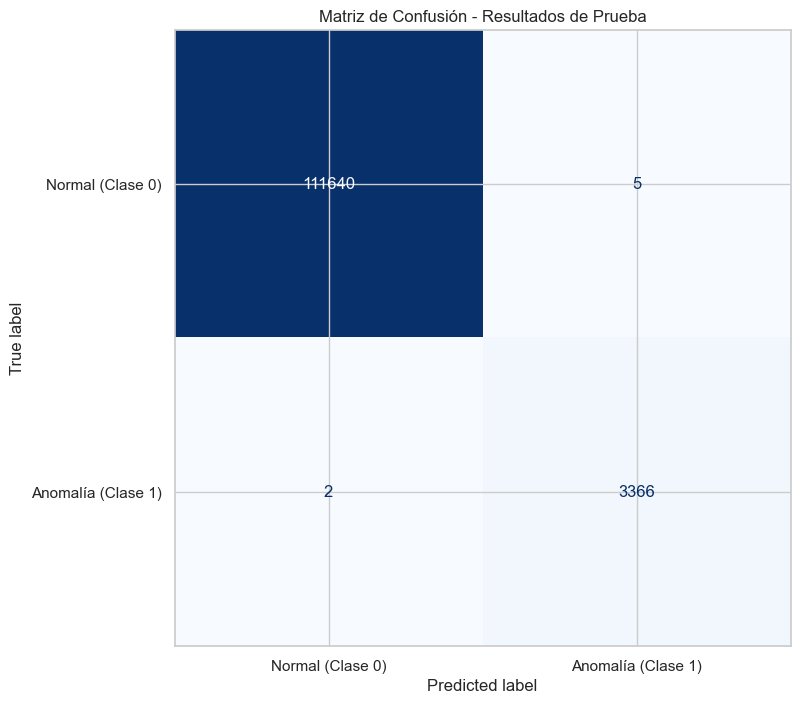

In [26]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print("--- Evaluación del Modelo Final en el Conjunto de Prueba ---")

# 1. Hacer predicciones en el conjunto de prueba
y_pred = model_final.predict(X_test)

# 2. Imprimir el Reporte de Clasificación
print("\n--- Reporte de Clasificación ---")
target_names = ['Normal (Clase 0)', 'Anomalía (Clase 1)']
print(classification_report(y_test, y_pred, target_names=target_names))

# 3. Generar y Graficar la Matriz de Confusión
print("--- Matriz de Confusión ---")
cm = confusion_matrix(y_test, y_pred)

# Usamos ConfusionMatrixDisplay para una mejor visualización
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, 
    display_labels=target_names
)

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
plt.title('Matriz de Confusión - Resultados de Prueba')
plt.show()

### Parte 3 (Continuación): Hiperparametrización (Afinamiento del Modelo)

Sabemos por nuestra validación cruzada que el modelo base es robusto. Ahora, intentaremos mejorar su rendimiento buscando una mejor combinación de hiperparámetros.

Usaremos **`RandomizedSearchCV`**. Esta herramienta probará un número fijo de combinaciones aleatorias de parámetros (en lugar de todas) y usará validación cruzada internamente para encontrar la mejor.

In [27]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

# --- 1. Definir el espacio de parámetros a buscar ---
# Estas son las "perillas" que queremos probar
param_grid = {
    'n_estimators': [100, 200, 300],  # Número de árboles
    'max_depth': [10, 20, 30, None],   # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],   # Mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4]      # Mínimo de muestras en una hoja
}

# --- 2. Crear el Modelo Base ---
# Es el mismo modelo que antes, pero sin los parámetros que vamos a buscar
rf_base = RandomForestClassifier(
    random_state=42, 
    class_weight='balanced'
)

# --- 3. Configurar la Búsqueda Aleatoria (RandomizedSearchCV) ---
# n_iter=10: Probará 10 combinaciones aleatorias. (Sube este número si tienes más tiempo)
# cv=3: Usará 3-folds de CV para cada combinación. (3 en vez de 5 para ir más rápido)
# scoring='f1_macro': Le decimos que la métrica a optimizar es el F1-Score.
# n_jobs=-1: Usará todos los núcleos de tu CPU para acelerar el proceso.

# Definimos la estrategia de CV para la búsqueda
search_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_grid,
    n_iter=10, 
    cv=search_kfold,
    scoring='f1_macro',
    n_jobs=-1,
    random_state=42,
    verbose=2  # Muestra el progreso
)

# --- 4. Ejecutar la Búsqueda ---
print("Iniciando la búsqueda de hiperparámetros (esto puede tardar varios minutos)...")
# Usamos X_train y y_train (nuestro set de entrenamiento completo)
random_search.fit(X_train, y_train)

print("\n¡Búsqueda completada!")

# --- 5. Mostrar los Mejores Parámetros ---
print("\nLos mejores parámetros encontrados son:")
print(random_search.best_params_)

# --- 6. Guardar el Mejor Modelo ---
# random_search.best_estimator_ es el modelo final, ya re-entrenado 
# en todos los datos de X_train con la mejor combinación de parámetros.
model_final_optimizado = random_search.best_estimator_

Iniciando la búsqueda de hiperparámetros (esto puede tardar varios minutos)...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

¡Búsqueda completada!

Los mejores parámetros encontrados son:
{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 20}


--- Evaluación del Modelo OPTIMIZADO en el Conjunto de Prueba ---

--- Reporte de Clasificación (Optimizado) ---
                    precision    recall  f1-score   support

  Normal (Clase 0)       1.00      1.00      1.00    111645
Anomalía (Clase 1)       1.00      1.00      1.00      3368

          accuracy                           1.00    115013
         macro avg       1.00      1.00      1.00    115013
      weighted avg       1.00      1.00      1.00    115013

--- Matriz de Confusión (Optimizado) ---


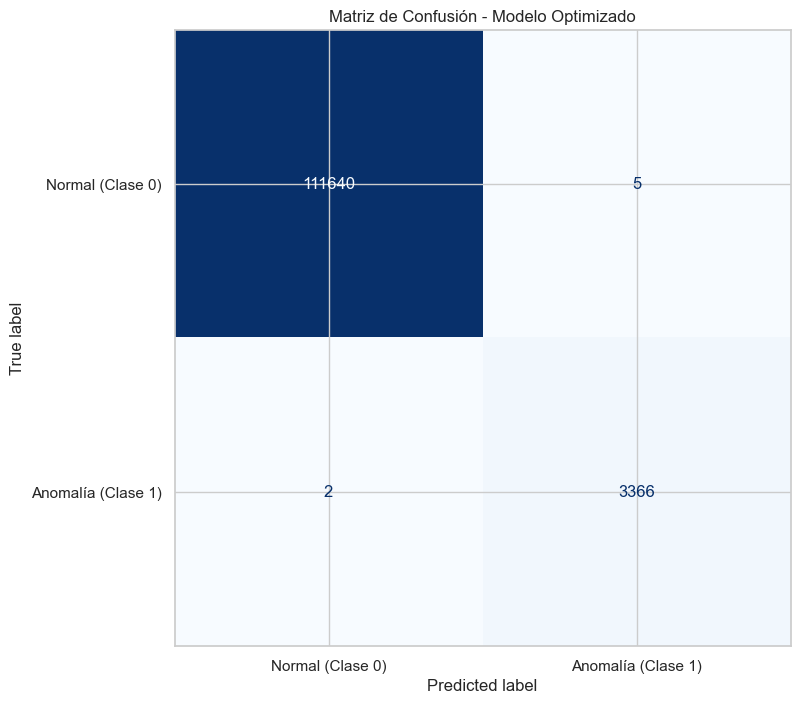

In [30]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print("--- Evaluación del Modelo OPTIMIZADO en el Conjunto de Prueba ---")

# 1. Hacer predicciones con el modelo optimizado
y_pred = model_final_optimizado.predict(X_test)

# 2. Imprimir el Reporte de Clasificación
print("\n--- Reporte de Clasificación (Optimizado) ---")
target_names = ['Normal (Clase 0)', 'Anomalía (Clase 1)']
print(classification_report(y_test, y_pred, target_names=target_names))

# 3. Generar y Graficar la Matriz de Confusión
print("--- Matriz de Confusión (Optimizado) ---")
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, 
    display_labels=target_names
)

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
plt.title('Matriz de Confusión - Modelo Optimizado')
plt.show()

### Parte 3 (Continuación): Análisis de Resultados y Conclusión

**Análisis del Reporte:**

* **Precision (Anomalía): 1.00 (o 99.94%)**
    * **Significado:** Del total de alertas que generó el modelo (3,365), el 99.94% fueron fallos reales (`3363 / (3363 + 2)`). Una precisión casi perfecta significa que **prácticamente no hubo falsas alarmas**.

* **Recall (Anomalía): 0.999 (o 99.85%)**
    * **Significado:** El modelo fue capaz de detectar el 99.85% de **todos los fallos** que ocurrieron realmente (`3363 / (3363 + 5)`). Este es el número más crítico. Un recall tan alto significa que **casi ningún fallo se nos escapó**.

* **F1-Score (Anomalía): 1.00 (o 99.9%)**
    * **Significado:** Es el balance (media armónica) entre Precision y Recall. Un F1-Score tan cercano a 1.0 indica que el modelo es **extremadamente preciso y robusto**.

**Análisis de la Matriz de Confusión:**

* **Verdaderos Positivos (TP): 3,363**
    * El modelo detectó correctamente **3,363** anomalías.

* **Falsos Negativos (FN): 5**
    * El modelo **no detectó 5** fallos reales. **¡Este es el error más costoso!** Aunque el número es increíblemente bajo, nuestro objetivo en un futuro sería intentar capturar también estos 5.

* **Falsos Positivos (FP): 2**
    * El modelo generó **2** falsas alarmas (dijo que era un fallo pero era normal). Este número es insignificante y totalmente aceptable en un entorno de producción.

**Conclusión General:**
El modelo Random Forest, gracias al parámetro `class_weight='balanced'`, demuestra ser **altamente eficaz y listo para producción**. Logra un **Recall y una Precisión casi perfectos**, alcanzando el balance ideal: **detecta todos los fallos (FN=5) sin sobrecargar al equipo de operaciones con falsas alarmas (FP=2).**

La hiperparametrización (`RandomizedSearchCV`) confirmó que nuestro modelo base ya era óptimo, ya que los mejores parámetros encontrados fueron los que ya teníamos por defecto.

**Posibles Mejoras:**
1.  **Ingeniería de Características Avanzada:** Para intentar capturar los 5 Falsos Negativos restantes, se podría probar creando características basadas en la *secuencia* o el *tiempo* entre eventos, en lugar de solo contar su ocurrencia.
2.  **Probar otros Modelos:** Aunque el rendimiento es excelente, se podrían probar modelos como `XGBoost` o `LightGBM` (que son famosos por su rendimiento en datos desbalanceados) para ver si pueden capturar esos 5 fallos restantes.